# Vector Data Products
This notebook is meant to showcase end-to-end automation snippets for creating and maintaining data products in ArcGIS. This has a few components:
* Hosting the data as a service in ArcGIS
* Create a user view of the data
* Create a map from the view
* Create an app from the map
* Share the outputs to the user
* Manage updates

In [1]:
import tempfile
import shutil
import json
import pandas as pd
from arcgis.gis import GIS, Item
from arcgis.features import FeatureLayerCollection, FeatureLayer
from arcgis.mapping import WebMap
from arcgis.geometry import Geometry

***Note**, if you are unable to import local `partnerutils`, **copy the following functions** from [`clone_utils`](https://github.com/mpayson/esri-partner-tools/blob/master/partnerutils/clone_utils.py)

In [2]:
from partnerutils.clone_utils import clone_items_modify

**GIS**: Your GIS instance, parameter information [here](https://developers.arcgis.com/python/guide/using-the-gis/). Not specifying a password creates a password prompt

In [3]:
gis = GIS(username="mspatialstartups")

Enter password:  ·················


## Host data
Add vector data to a [hosted feature layer](https://doc.arcgis.com/en/arcgis-online/reference/feature-layers.htm) in ArcGIS. Hosted feature layers are managed and interacted with through the [feature service REST API](https://developers.arcgis.com/rest/services-reference/feature-service.htm). 

This is one approach to add data, the [feature layer samples](https://github.com/mpayson/esri-partner-tools/tree/master/feature_layers) have additional workflows with the Python API. There are other approaches, like [publishing](https://pro.arcgis.com/en/pro-app/help/sharing/overview/web-feature-layer.htm) from [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) or [ETLing](https://enterprise.arcgis.com/en/geoevent/latest/process-event-data/output-connectors.htm) from a live stream with [GeoEvent](https://enterprise.arcgis.com/en/geoevent/), but these are out of scope.

**Note:** I'd strongly encourage [setting human readable display names for fields](https://github.com/mpayson/esri-partner-tools/blob/master/feature_layers/manage_fields.ipynb)--this will propogate to all applications. You can also [update the indexes](https://github.com/mpayson/esri-partner-tools/blob/master/feature_layers/manage_indexes.ipynb) for commonly queried fields.

In [4]:
# adds the CSV as a hosted feature layer
df = pd.read_csv(
    '../sample_data/NYC_Restaurant_Inspections.csv',
    parse_dates=['INSPECTION DATE', 'GRADE DATE', 'RECORD DATE'],
    encoding='utf-8'
)
sdf = pd.DataFrame.spatial.from_xy(df, 'Longitude', 'Latitude')

lyr_item = sdf.spatial.to_featurelayer(
    'VDP NYC Restaurant Inspections',
    tags="vdp__sample"
)

In [5]:
# get a reference to the FeatureLayer
lyr = lyr_item.layers[0]

# Update the layer with a similarly meaningful title to the exposed item
lyr.manager.update_definition({"name": "VDP_NYC_Restaurant_Inspections_Layer"})

# make the item authoritative so it's easier to find and isn't easily deleted
lyr_item.content_status = 'authoritative'

lyr_item

<Item title:"VDP NYC Restaurant Inspections" type:Feature Layer Collection owner:mspatialstartups>

## Create a user view

Alright, your data is hosted! Now, let's say the user is requesting access to your data. 
You likely don't want to give users access to the authoritative layer and, often, you may not want to give end users access to the entire dataset (maybe there are internal fields or they only purchased a subset). In this case, you can create [feature layer views](https://doc.arcgis.com/en/arcgis-online/manage-data/create-hosted-views.htm) against one authoritative layer and give them access to that view.

Note, I'm only creating a SQL subset, but there's a whole [views notebook](https://github.com/mpayson/esri-partner-tools/blob/master/feature_layers/create_views.ipynb) with more options.

In [6]:
# create the view
flc = FeatureLayerCollection.fromitem(lyr_item)
view_lyr_item =  flc.manager.create_view(
    'VDP Manhattan Restaurant Inspections',
    allow_schema_changes=True,
    updateable=True,
    capabilities='Query'
)

# update properties
view_lyr_item.update(item_properties={'tags': 'vdp__sample'})
view_lyr_item.content_status = 'authoritative'

# define visible data
view_lyr = view_lyr_item.layers[0]
where = "BORO = 'Manhattan'"
view_lyr.manager.update_definition({
    "viewDefinitionQuery": where,
    "name": "VDP_Manhattan_Restaurant_Inspections"
})

# get extent information, the layer and the underlying service
# expect the extent in different formats and crs :/
view_lyr_extent = view_lyr.query(return_extent_only=True)['extent']
view_lyr_item_extent = view_lyr.query(return_extent_only=True, out_sr=4326)['extent']
_v = view_lyr_item_extent
view_lyr_item_extent_str = str(
    [[_v['xmin'], _v['ymin']],[_v['xmax'], _v['ymax']]]
)

view_lyr_item

<Item title:"VDP Manhattan Restaurant Inspections" type:Feature Layer Collection owner:mspatialstartups>

#### Configure the view
In addition to provisioning the data, you can style and configure the data so end users have a default, on-brand experience. **ArcGIS provides a strong authoring UI, so I'd highly recommend designing in ArcGIS Online (eg [set style](https://doc.arcgis.com/en/arcgis-online/create-maps/change-style.htm) | [configure popups](https://doc.arcgis.com/en/arcgis-online/create-maps/configure-pop-ups.htm) then [save the layer](https://doc.arcgis.com/en/arcgis-online/create-maps/copy-save-layers.htm#ESRI_SECTION1_9F4C867CA85B4E4DA5945EF1C8BBC3E0) and [edit the item overview](https://doc.arcgis.com/en/arcgis-online/manage-data/item-details.htm#ESRI_SECTION1_D770A2AE32F647DCA47F48622D460B6D)) and using the output as a "template".**

Here, I've already created a template layer, and use the properites of that template to set the properties of the newly created view. The template is public, so check it out (and please don't fault the cartography)!

<Item title:"VDP NYC Inspection Template Layer" type:Feature Layer Collection owner:mpayson_startups>
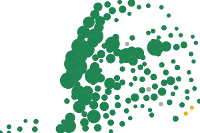

In [7]:
lyr_template_item = Item(gis, 'b71c61e14425426984ec8a1a94bb77f4')
lyr_template_item

Copy item-level schema. Note the data model needs to be the same. Where these properties live is admittedly confusing.

In [8]:
# overview properties
template_item_properties = dict(lyr_template_item)
copy_item_properties = {
    p: template_item_properties[p]
    for p in ['description', 'snippet', 'licenseInfo']
}
copy_item_properties['extent'] = view_lyr_item_extent_str

# data properties, this includes popup, clustering, default filters...
copy_item_data = json.dumps(lyr_template_item.get_data())

# thumbnail
dirpath = tempfile.mkdtemp()
thumbnail_path = lyr_template_item.download_thumbnail(dirpath)

# send it!
view_lyr_item.update(
    copy_item_properties, copy_item_data, thumbnail_path
)
shutil.rmtree(dirpath)

Copy service-level properties. In this case style / renderer, visible range, and data extent. Note the data model needs to be the same.

<Item title:"VDP Manhattan Restaurant Inspections" type:Feature Layer Collection owner:mspatialstartups>
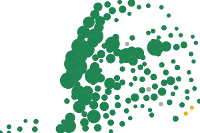

In [9]:
template_lyr_properties = dict(lyr_template_item.layers[0].properties)
copy_lyr_properties = {
    p: template_lyr_properties[p]
    for p in ['drawingInfo', 'minScale', 'maxScale']
}
copy_lyr_properties['extent'] = view_lyr_extent

view_lyr.manager.update_definition(copy_lyr_properties)

view_lyr_item

## Create a map

[x] data created [x] user view created! We could just provision the data view to the user and call it a day. Or, we could take it a step further and deliver an information product.

A [web map](https://developers.arcgis.com/documentation/core-concepts/web-maps/) is an item that represents multiple layers, drawing information, and additional configurations (stored in a JSON object) that's supported across ArcGIS. Just like the individual layer, **I'd recommend authoring a template Web Map in ArcGIS Online then copying that template and replacing the layer.**

Here's a template web map--it has a defualt dark basemap as well as restaurant spending demograhpic data from the [Living Atlas](https://livingatlas.arcgis.com/en/).

<Item title:"VDP NYC Inspection Template Map" type:Web Map owner:mpayson_startups>
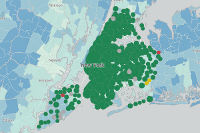

In [10]:
map_template_item = Item(gis, 'd6fa05bdaa05415dae8b1bc22b4e3185')
map_template_item

In [11]:
# create a clone with most of the same properties
map_item_mapping = {
    lyr_template_item.id: view_lyr_item.id
}

map_update_lambda = lambda c_item, t_gis: (
    {'title': 'VDP Manhattan Restaurant Inspection Map',
     'tags': 'vdp__sample',
     'extent': view_lyr_item_extent_str}
    if c_item.type == 'Web Map' else
    {'tags': 'vdp__sample'}
)

map_clone_res = clone_items_modify(
    [map_template_item],
    gis,
    map_update_lambda,
    search_existing_items=False,
    copy_data=False,
    item_mapping=map_item_mapping
)

map_item = [i for i in map_clone_res if i.type=='Web Map'][0]
map_item.content_status = 'authoritative'

<Item title:"VDP Manhattan Restaurant Inspection Map" type:Web Map owner:mspatialstartups>
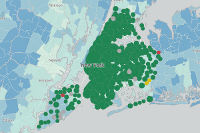

In [12]:
# update the layer title in the webamp
# note, there's a bug where a view layer won't be swapped for another view layer?
# this should update the title but also account for the bug

webmap_dict = dict(map_item.get_data())
[temp_lyr_i, temp_map_lyr] = [
    (i, l) for i, l in enumerate(webmap_dict['operationalLayers'])
    if l['itemId'] == view_lyr_item.id or l['itemId'] == lyr_template_item.id
][0]

update_map_lyr = {
    **temp_map_lyr,
    'title': view_lyr_item.title,
    'itemId': view_lyr_item.id,
    'url': view_lyr.url
}

webmap_dict['operationalLayers'][temp_lyr_i] = update_map_lyr
map_item.update(data=json.dumps(webmap_dict))

map_item

## Create an app
Believe it or not, we're going to take a similar approach to the layers and maps, where we've already built a template app in Online, and are now cloning it with updated dependencies. **Here's more information about [creating configurable apps](https://doc.arcgis.com/en/arcgis-online/create-maps/create-map-apps.htm)**, and here's the app (built with [Operations Dashboard](https://www.esri.com/en-us/arcgis/products/operations-dashboard/overview)):

<Item title:"VDP NYC Inspection Template App" type:Dashboard owner:mpayson_startups>
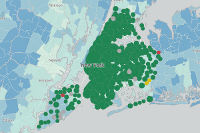

In [13]:
app_template_item = Item(gis, '19288bca6012497c994b47c1a4f5e5a2')
app_template_item

<Item title:"VDP Manhattan Restaurant Inspection Dashboard" type:Dashboard owner:mspatialstartups>
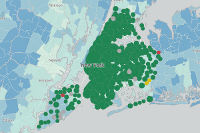

In [14]:
app_item_mapping = {
    map_template_item.id: map_item.id,
    lyr_template_item.id: view_lyr_item.id
}

# update cloned properties, if dashboard rename
app_update_lambda = lambda c_item, t_gis: (
    {'title': 'VDP Manhattan Restaurant Inspection Dashboard',
     'tags': 'vdp__sample'}
    if c_item.type == 'Dashboard' else
    {'tags': 'vdp__sample'}
)

# create a clone of most of the properties
app_clone_res = clone_items_modify(
    [app_template_item],
    gis,
    app_update_lambda,
    search_existing_items=False,
    copy_data=False,
    item_mapping=app_item_mapping
)
app_item = [i for i in app_clone_res if i.type=='Dashboard'][0]
app_item.content_status = 'authoritative'

app_item

## Share with users
Now that the data, maps, and apps are set up, they need to be shared. One option is to add these items as listings on the [Marketplace](https://marketplace.arcgis.com/?start=1&view=grid&sortOrder=desc&sortField=uploaded). Marketplace automatically handles provisioning, trials, e-commerce, etc ([more](https://doc.arcgis.com/en/marketplace/provider/become-a-provider.htm)). In some cases, this isn't a fit--another option is to leverage ArcGIS Online's multi-tenancy and share the items with users via [groups](https://doc.arcgis.com/en/arcgis-online/share-maps/groups.htm).

This section walks through creating and sharing data to a group. If of interest, there are also notebooks on [creating groups](https://github.com/mpayson/esri-partner-tools/blob/master/build_org/create_share_group.ipynb), [cloning groups](https://github.com/mpayson/esri-partner-tools/blob/master/build_org/clone_groups.ipynb), and [distributing items](https://github.com/mpayson/esri-partner-tools/blob/master/common_workflows/distribute_items.ipynb).

In [15]:
# create a group
group_schema = {
    "title": "End User Organization ABC",
    "tags": "test, group, poc, scripts",
    "description": "A group to distribute data products to ABC",
    "access": 'private',
    "is_invitation_only": True,
    "users_update_items": False
}
group = gis.groups.create_from_dict(group_schema)

# add users via their ArcGIS Online user name
# users will receive a notification to accept the invite
usernames=['mpayson_startups']
group.invite_users(usernames)

# share the outputs to the group
items = [view_lyr_item, map_item, app_item]
gis.content.share_items(items, groups=[group])

# create and add the output to a folder, so it's more organized in your view
folder = gis.content.create_folder("End User Organization ABC")
move_results = [i.move("End User Organization ABC") for i in items]

## Manage updates
Users have access to the data! Now what happens if things change? If you update the data in the original service ([notebook](https://github.com/mpayson/esri-partner-tools/blob/master/feature_layers/update_data.ipynb)), that data will propogate through all the views, maps, and apps. Beyond that, schema changes, template UI tweaks, etc will not propogate.

To show how each item can be updated, let's: add a new field to the layer, add the field to the views, and plot the new field in the dashboard. This section references existing items from the notebook, in production I'd recommend saving IDs to a user store

#### Apply mock updates to the layer

In [16]:
# manually add a field and set the default value
new_field = {
    "name": "new_field",
    "type": "esriFieldTypeDouble",
    "alias": "New Field",
    "nullable": True,
    "editable": True,
    "visible": True,
}
lyr.manager.add_to_definition({"fields": [new_field]})

import numpy as np
oid_res = lyr.query(return_ids_only=True)
edits = [
    {"attributes": {oid_res['objectIdFieldName']: o, 'new_field': np.random.poisson()}}
    for o in oid_res['objectIds']
]
edit_res = lyr.edit_features(updates=edits)

#### Add new field to views

In [17]:
# all fields should be visible
fields = list(map(
    lambda f: {
        'name': f.name,
        'visible': True
    },
    lyr.properties.fields
))

view_lyr.manager.update_definition({"fields": fields})

{'success': True}

#### Update the dashboard
The general approach is to create a new item like above then copy the resulting item JSON and delete the new item. Same for webmaps. This is admittedly kludgy, but it allows us to rely on the Python API to create the appropriate representation.


In [18]:
# this could be, and likely will be, the same item as before
# but for reproducing this notebook I made a new item
upd_app_template_item = Item(gis, '93095eeed60f40eabc7997978bcd7307')
upd_app_item_mapping = {
    '2d2c58d3bad14056a037e3915cba27cb': map_item.id,
    '53f0d54fe2194824a779b010e998a465': view_lyr_item.id
}
upd_app_clone_res = gis.content.clone_items(
    [upd_app_template_item],
    search_existing_items=False,
    copy_data=False,
    item_mapping=upd_app_item_mapping
)
upd_app_item = [i for i in upd_app_clone_res if i.type=='Dashboard'][0]

<Item title:"VDP Manhattan Restaurant Inspection Dashboard" type:Dashboard owner:mspatialstartups>
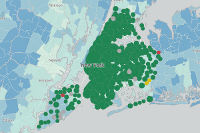

In [19]:
# this is the important part, add the new item configuration data
# to old item then delete the new item
upd_app_item_dict = upd_app_item.get_data()
app_item.update(data=json.dumps(upd_app_item_dict))

gis.content.delete_items(upd_app_clone_res)

app_item

## Clean up

In [20]:
delete_items = gis.content.search("tags:vdp__sample")
for item in delete_items:
    item.content_status = None
    item.protect(False)
gis.content.delete_items(delete_items)

gis.content.delete_folder("End User Organization ABC")
if group is not None:
    group.delete()